# Introduction to Data Science Project: Prediction Neural Networks

In [42]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


## Reading data

In [43]:
# Get data and clean it
df23 = pd.read_csv('23-24.csv', delimiter=';')
#drop last row of df23:
df23 = df23.drop(df23.index[-1])
df24 = pd.read_csv('24-25.csv', delimiter=';')
df = pd.concat([df23, df24])
df = df.drop(columns=['Pedido','Hora','Representante','Status','Observa��o','Cliente Desde',
                      'Devol','Cidade','UF','numero','numero2','telefone','NF','Method'])
df = df.dropna(axis=1, how='all') #drop all columns that are all NaN
df = df.dropna(axis=0, how='all') #this might drop everything
#translate column names from portuguese to english
df = df.rename(columns={'Data':'Date','Vendedor':'Seller',
                        'Quantidade':'Quantity',
                        'Total Bruto':'Gross', 'Pagamento':'Payment Method',
                        'Desconto':'Discount','Frete':'Shipping',
                        'datadecompra':'Purchase Date','Devolu��o':'Returned','L�quido':'Net',
                        'Cliente':'Client','Qtde':'Quantity'})

# Turn all commas into dots for decimal numbers (in Brazilian Portuguese, commas are used as decimal separators)
df = df.replace(',', '.', regex=True) #replace commas with dots


## Preparing Data for Neural Network

In [44]:
# Make non-numeric columns numeric (Date, Sales Representative, Client Age and Clients) 

#Date (make numeric)
# Convert to datetime
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'], format='%d/%m/%Y')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

#Compute the Client's age in days:

# Get the most recent date in dataset
latest_date = df['Purchase Date'].max()
client_age = df.groupby('Client')['Date'].min().apply(lambda d: (latest_date - d).days)
# Merge client age back into full dataframe
df['Client Age'] = df['Client'].map(client_age)
df = df.drop(columns=['Date']) #drop date columns

# Purchase Date (turn into Last Purchase in days)
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'], format='%d/%m/%Y')
df= df.sort_values(by=['Client','Purchase Date'])
df['Last Purchase'] = df.groupby('Client')['Purchase Date'].diff().dt.days
df = df.drop(columns=['Purchase Date']) #drop purchase date column

#Seller (remove 04 and then one hot encode)
df = df[df.Seller != '04'] #drop seller 04. I don't know what 04 means, so I will drop it.
df = pd.get_dummies(df, columns=['Seller'], prefix='Seller')

#Payment Method (don't include)
df = df.drop(columns=['Payment Method']) #drop payment method column

#Clients
# There are more than 600 clients, so we will not one hot encode them. 
# Instead, we will plot the Gross, Quantity, and Date features of each client and 
# use K means clustering to categorize them.
# Using these new categories, we will one hot encode them.

# Find any cell that literally contains the problematic string
# Convert critical columns to numeric safely
for col in ['Gross', 'Quantity', 'Client Age']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df[df.Client != ''] #drop empty clients
# Show rows that were invalid
bad_rows = df[df.isna().any(axis=1)]
# if not bad_rows.empty:
#     print("Dropping rows with malformed numbers:")
#     print(bad_rows[['Client', 'Gross', 'Quantity', 'Client Age']])

# Drop rows that still contain NaNs after coercion
df = df.dropna(subset=['Gross', 'Quantity', 'Client Age'])

client_features = df.groupby('Client').agg({
    'Gross': 'sum',
    'Quantity': 'sum',
    'Client Age': 'first'  
}).fillna(0)
X_client = StandardScaler().fit_transform(client_features)
kmeans = KMeans(n_clusters=6, random_state=45)
clusters = kmeans.fit_predict(X_client)

# Map clusters back to original df
client_cluster_map = dict(zip(client_features.index, clusters))
df['Client Cluster'] = df['Client'].map(client_cluster_map)
df = df.drop(columns=['Client']) #drop client column
df = pd.get_dummies(df, columns=['Client Cluster'], prefix='Cluster')

# Final Cleaning
df = df.dropna()


# Get input data
X = df.drop(columns=['Gross']) #drop gross column
X = X.astype(np.float32) #convert to float32
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Get target data
y = df['Gross'] #get gross column
y = y.astype(np.float32) #convert to float32
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()


## Turn data into tensors

In [45]:
# turn into tensors
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

X_tensor = torch.tensor(X.values, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check for NaN and Inf values in the tensors
print("Checking for NaN and Inf values in tensors:")
print(torch.isnan(X_tensor).any(), torch.isinf(X_tensor).any(), X_tensor.max(), X_tensor.min())
print(torch.isnan(y_tensor).any(), torch.isinf(y_tensor).any(), y_tensor.max(), y_tensor.min())


Checking for NaN and Inf values in tensors:
tensor(False) tensor(False) tensor(77870.7031) tensor(-5327.9399)
tensor(False) tensor(False) tensor(11.0950) tensor(-0.9103)


## Define model 1 (not used):

In [46]:
# Define the neural network model (SIMPLE ARCHITECTURE)
# This is a simple feedforward neural network with two hidden layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(X_tensor.shape[1], 300)  # Input layer
        self.fc2 = nn.Linear(300, 150) # Hidden layer
        self.fc3 = nn.Linear(150, 32) # Hidden layer
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = NeuralNetwork()

# This model is not working well, so we will try a different one

For the above neural network, the gradients were exploding into infinity; therefore, I decided to train a different model.

## Define Model 2 (used):

In [47]:
#second model (STABLENET)
# More complex neural network with batch normalization and dropout
class StableNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)
    
model2 = StableNet(X_tensor.shape[1])

## NN optimizer and criterion and training

In [48]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.00025)

# Prepare data for training
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train the model
losses = []
epochs = 50
for epoch in range(epochs):
    epoch_losses = []
    for batch_X, batch_y in dataloader:
        # Forward pass
        predictions = model2(batch_X)
        loss = criterion(predictions, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    # Store average loss for the whole epoch
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_loss)

    # Print loss for every epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/50, Loss: 0.030570313334465027
Epoch 2/50, Loss: 0.8668935894966125
Epoch 3/50, Loss: 0.04708019644021988
Epoch 4/50, Loss: 0.04441186785697937
Epoch 5/50, Loss: 0.05356324836611748
Epoch 6/50, Loss: 0.07866987586021423
Epoch 7/50, Loss: 0.012562054209411144
Epoch 8/50, Loss: 0.160044863820076
Epoch 9/50, Loss: 0.07184049487113953
Epoch 10/50, Loss: 0.14872436225414276
Epoch 11/50, Loss: 0.07196369022130966
Epoch 12/50, Loss: 0.021384824067354202
Epoch 13/50, Loss: 0.9240339398384094
Epoch 14/50, Loss: 0.44971469044685364
Epoch 15/50, Loss: 0.05255754664540291
Epoch 16/50, Loss: 0.034200556576251984
Epoch 17/50, Loss: 0.05835219472646713
Epoch 18/50, Loss: 0.04336993023753166
Epoch 19/50, Loss: 0.019836904481053352
Epoch 20/50, Loss: 0.03644363954663277
Epoch 21/50, Loss: 0.015863517299294472
Epoch 22/50, Loss: 0.06726307421922684
Epoch 23/50, Loss: 0.01644858345389366
Epoch 24/50, Loss: 0.029603751376271248
Epoch 25/50, Loss: 0.020011281594634056
Epoch 26/50, Loss: 0.104209177

## Plotting results

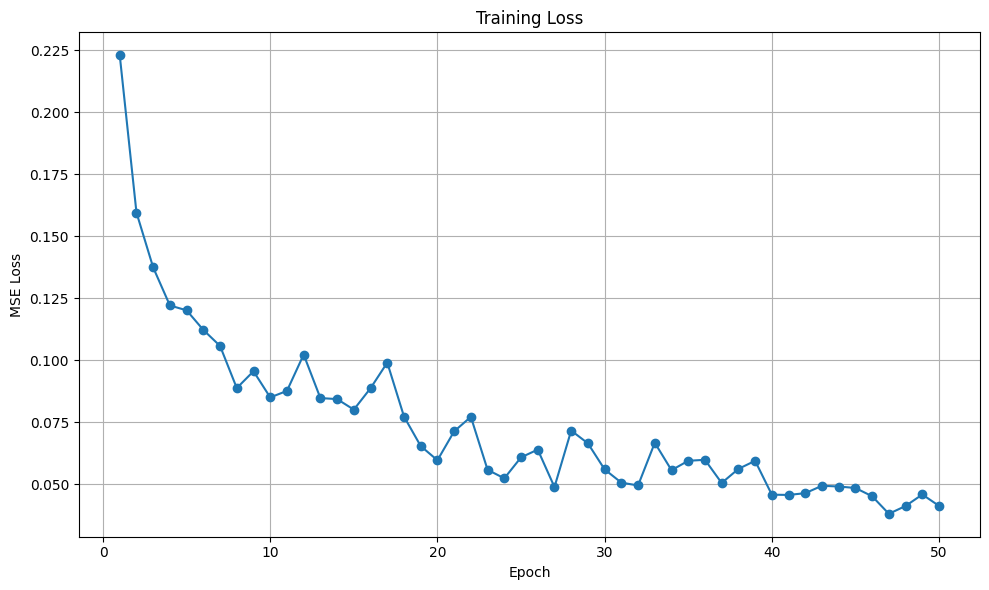

In [49]:
# Save the model
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.grid(True)
plt.tight_layout()
plt.show()



## See results

In [51]:
model2.eval() 
with torch.no_grad():
    predictions = model2(X_tensor)
# Convert to NumPy and reshape
predictions_np = predictions.numpy().reshape(-1, 1)

# Inverse transform using your scaler
predictions_original = scaler_y.inverse_transform(predictions_np).flatten()

# Also get the true gross values in original scale
true_gross = scaler_y.inverse_transform(y_tensor.numpy().reshape(-1, 1)).flatten()

results_df = pd.DataFrame({
    'Predicted Gross': predictions_original,
    'Actual Gross': true_gross
})
print(results_df.head(10))  # Display the first 10 rows
# results_df.to_csv('model_predictions.csv', index=False)


   Predicted Gross  Actual Gross
0      2895.527100   2625.100098
1      1939.880249   1129.300171
2      2694.773682   2168.800049
3      1851.314575   1004.300232
4      2442.087158   1838.900024
5      2938.411865   2503.500000
6      2502.889404   1918.799927
7      3964.522949   3797.699951
8      3082.237549   2648.500000
9      2821.307129   2345.800049
